In [1]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
path_Covid = r'COVID-19_Radiography_Dataset\COVID'
path_Normal = r'COVID-19_Radiography_Dataset\Normal'
path_Opacity = r'COVID-19_Radiography_Dataset\Lung_Opacity'
path_Pneumonia = r'COVID-19_Radiography_Dataset\Viral Pneumonia'

In [15]:
#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
#num_images = 10000
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    #images = np.zeros((num_images, height, width))
    #i = 0
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1,as_gray=True)[:,:]
        #print(path1)
        images[count] = originalImage
        #i+=1
        #if i==num_images:
        #    break;
    imshow(images[0])
    plt.show()
    return images

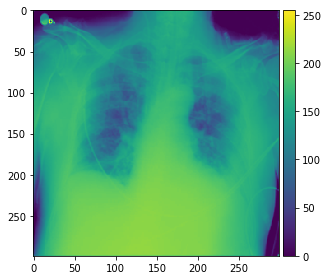

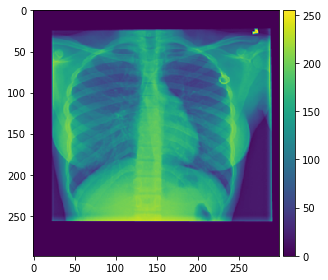

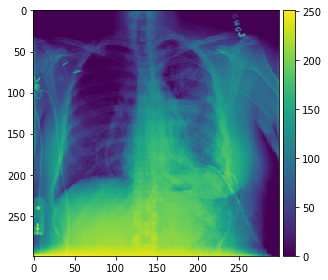

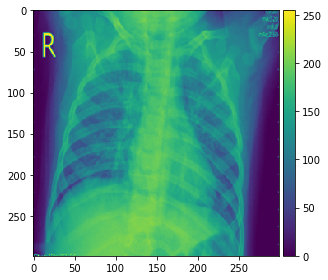

In [16]:
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)
opacity = imageReading(path_Opacity)
pneumonia = imageReading(path_Pneumonia)

In [17]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299))
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299))
opacity = torch.from_numpy(np.array(opacity).reshape(-1,1,299,299))
pneumonia = torch.from_numpy(np.array(pneumonia).reshape(-1,1,299,299))

In [33]:
print(len(img_covidlist), len(img_normallist), opacity.shape[0], pneumonia.shape[0])

3616 10192 6012 1345


In [18]:
img_covidlist = []
for i in range(covid.shape[0]):
    img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
    img_normallist.append((normal[i]/255.0,1.0))
    
img_opacitylist = []
for i in range(opacity.shape[0]):
    img_opacitylist.append((opacity[i]/255.0,2.0))

img_pneumonialist = []
for i in range(pneumonia.shape[0]):
    img_pneumonialist.append((pneumonia[i]/255.0,3.0))    

In [37]:
#### límites para dividr la data 70% para training 30% para testing
# Covid
start = 0
training_limit_covid = int(len(img_covidlist)*0.70)
val_limit_covid = int(len(img_covidlist)*0.90)
end_covid = len(img_covidlist)

# normal
training_limit_normal = int(len(img_normallist)*0.70)
val_limit_normal = int(len(img_normallist)*0.90)
end_normal = len(img_normallist)

# Opacity
training_limit_opacity = int(len(img_opacitylist)*0.70)
val_limit_opacity = int(len(img_opacitylist)*0.90)
end_opacity = len(img_opacitylist)

# Pneumonía
training_limit_pneumonia = int(len(img_pneumonialist)*0.70)
val_limit_pneumonia = int(len(img_pneumonialist)*0.90)
end_pneumonia = len(img_pneumonialist)

In [38]:
import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:training_limit_covid]
covid_val = img_covidlist[training_limit_covid:val_limit_covid]
covid_test = img_covidlist[val_limit_covid:end_covid]

random.shuffle(img_normallist)
normal_train = img_normallist[0:training_limit_normal]
normal_val = img_normallist[training_limit_normal:val_limit_normal]
normal_test = img_normallist[val_limit_normal:end_normal]

random.shuffle(img_opacitylist)
opacity_train = img_opacitylist[0:training_limit_opacity]
opacity_val = img_opacitylist[training_limit_opacity:val_limit_opacity]
opacity_test = img_opacitylist[val_limit_opacity:end_opacity]

random.shuffle(img_pneumonialist)
pneumonia_train = img_pneumonialist[0:training_limit_pneumonia]
pneumonia_val = img_pneumonialist[training_limit_pneumonia:val_limit_pneumonia]
pneumonia_test = img_pneumonialist[val_limit_pneumonia:end_pneumonia]

In [39]:
train_beta = covid_train + normal_train + opacity_train + pneumonia_train
val_beta = covid_val + normal_val + opacity_val + pneumonia_val
test_beta = covid_test + normal_test + opacity_test + pneumonia_test
random.shuffle(train_beta)
random.shuffle(val_beta)
random.shuffle(test_beta)

In [40]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

In [156]:
#hypengrparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=1), # 300
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0)) #150 x 150
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),#146
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),#36
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),#36
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
            nn.Linear(128*9*9, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        #print('aviso1')
        out = self.layer2(out)
        #print('aviso2')
        out = self.layer3(out)
        out = self.layer4(out)
        #print('aviso3')
        out = out.reshape(out.size(0), -1)
        #print('aviso4')
        out = self.fc(out)
        return out 

In [157]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [158]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=10368, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=4, bias=True)
  )
)


In [161]:
def validation(model, device, val_loader, loss_function):
    # Settings
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            inputs = images.float().to(device)
            labels = labels.long().to(device)

            outputs = model(inputs).float()
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(val_loader)

In [162]:
def train(model, optimizer, loos_fn, num_epochs):
  loss_vals = []
  running_loss =0.0
  ultimo_loss = 100
  umbral_loss = 3
  times = 0
  # train the model
  total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

  list_loss= []
  train_list=[]
  val_list=[] 
  list_time = []
  j=0

  for epoch in range(num_epochs):
    train_loss = 0   
    for i, (images, labels) in enumerate(train_loader):
      images = images.float().to(device)
      labels = labels.long().to(device)
      # forward 
      output = model(images).float()
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
      train_loss += loss.item()
      list_time.append(j)
      j+=1
              
      if (i+1) % 20 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
    # Early stopping
    train_list.append(train_loss/len(train_loader))
    loss_actual = validation(model, device, val_loader, loos_fn)
    val_list.append(loss_actual)
    print('Ultimo loss:', ultimo_loss)
    print('Loss actual:', loss_actual)

    if loss_actual > ultimo_loss:
        times += 1
        print('times:', times)

        if times >= umbral_loss:
            print('Early stopping alcanzado.')
            return train_list, val_list

    else:
        print('trigger times: 0')
        times = 0

    ultimo_loss = loss_actual
    
              
  print('Finished Training Trainset')
  return train_list, val_list

In [163]:
error_train, error_val = train(model,optimizer,loss_fn,20)

Epoch [1/20], Step [20/926], Loss: 0.4726
Epoch [1/20], Step [40/926], Loss: 0.6273
Epoch [1/20], Step [60/926], Loss: 0.2760
Epoch [1/20], Step [80/926], Loss: 0.1720
Epoch [1/20], Step [100/926], Loss: 0.7520
Epoch [1/20], Step [120/926], Loss: 0.5633
Epoch [1/20], Step [140/926], Loss: 0.7168
Epoch [1/20], Step [160/926], Loss: 0.5251
Epoch [1/20], Step [180/926], Loss: 0.2245
Epoch [1/20], Step [200/926], Loss: 0.3471
Epoch [1/20], Step [220/926], Loss: 0.3279
Epoch [1/20], Step [240/926], Loss: 0.4765
Epoch [1/20], Step [260/926], Loss: 0.7349
Epoch [1/20], Step [280/926], Loss: 0.6477
Epoch [1/20], Step [300/926], Loss: 0.7354
Epoch [1/20], Step [320/926], Loss: 0.7520
Epoch [1/20], Step [340/926], Loss: 0.4135
Epoch [1/20], Step [360/926], Loss: 0.4499
Epoch [1/20], Step [380/926], Loss: 0.3479
Epoch [1/20], Step [400/926], Loss: 0.5273
Epoch [1/20], Step [420/926], Loss: 0.4016
Epoch [1/20], Step [440/926], Loss: 0.4373
Epoch [1/20], Step [460/926], Loss: 0.4926
Epoch [1/20], S

Epoch [5/20], Step [20/926], Loss: 0.2083
Epoch [5/20], Step [40/926], Loss: 0.0485
Epoch [5/20], Step [60/926], Loss: 0.0515
Epoch [5/20], Step [80/926], Loss: 0.0915
Epoch [5/20], Step [100/926], Loss: 0.4150
Epoch [5/20], Step [120/926], Loss: 0.0496
Epoch [5/20], Step [140/926], Loss: 0.0517
Epoch [5/20], Step [160/926], Loss: 0.3372
Epoch [5/20], Step [180/926], Loss: 0.1497
Epoch [5/20], Step [200/926], Loss: 0.1766
Epoch [5/20], Step [220/926], Loss: 0.2022
Epoch [5/20], Step [240/926], Loss: 0.0804
Epoch [5/20], Step [260/926], Loss: 0.0669
Epoch [5/20], Step [280/926], Loss: 0.2370
Epoch [5/20], Step [300/926], Loss: 0.0712
Epoch [5/20], Step [320/926], Loss: 0.0348
Epoch [5/20], Step [340/926], Loss: 0.1212
Epoch [5/20], Step [360/926], Loss: 0.3356
Epoch [5/20], Step [380/926], Loss: 0.0091
Epoch [5/20], Step [400/926], Loss: 0.0448
Epoch [5/20], Step [420/926], Loss: 0.2464
Epoch [5/20], Step [440/926], Loss: 0.1139
Epoch [5/20], Step [460/926], Loss: 0.6183
Epoch [5/20], S

In [164]:
with torch.no_grad():
      y_true = []
      y_pred = []  
      correct = 0
      total = 0
      for images, labels in test_loader:
          images, labels = images.float().to(device), labels.float().to(device)
           
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
            
          total += labels.size(0)
          y_true.append(labels.cpu().data.numpy()) 
          y_pred.append(predicted.cpu().data.numpy())  
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.62671071260029 %


In [165]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))

array([[343,   8,   9,   2],
       [ 20, 931,  61,   8],
       [ 25, 100, 477,   0],
       [  2,   5,   1, 127]], dtype=int64)

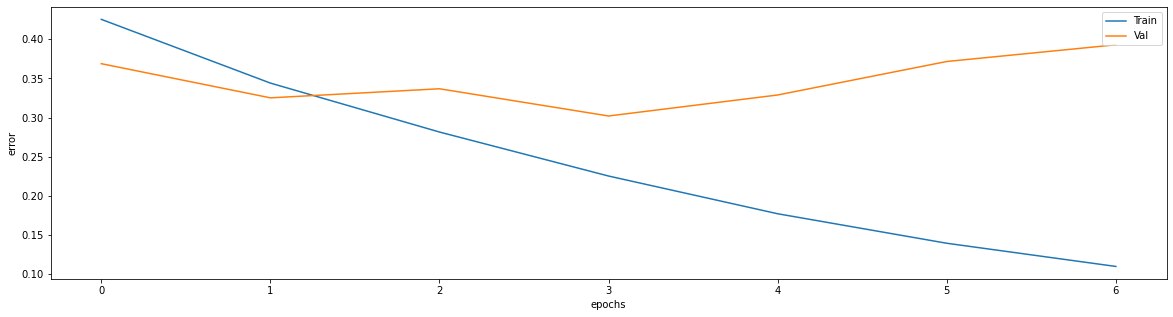

In [166]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(error_train)
plt.plot(error_val)
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend(["Train", "Val"], loc ="upper right")
plt.show()